In [291]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
dill.settings['recurse'] = True
from tqdm import tqdm
from triangle import triangulate, plot
from random import sample
from utils import get_global_normals_and_tangentials, get_local_normals_and_tangentials, get_middle_indices, get_delta_function

### Get precomputed integrals

In [292]:
biharmonic_functional = dill.load(open("calculations/FUNC_B", "rb"))
basis_integral_values = dill.load(open("calculations/FUNC_A", "rb"))

### Initialize the domain

In [293]:
t = np.linspace(0, 2*np.pi, 500, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

### Run triangulation

In [294]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="q30a0.001pneo2")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
vertex_maker_is_boundary = cndt["vertex_markers"]
print(f"Total number of points {points.shape[0]}")

Total number of points 12865


### Local normal and tangential vectors

In [295]:
elem_normal, elem_tangential = get_local_normals_and_tangentials(points, triangles)

### Global normal and tangential

In [296]:
global_elem_normal, global_elem_tangential = get_global_normals_and_tangentials(points, triangles)

### Separate middles

In [297]:
is_middle = get_middle_indices(points.shape[0], triangles)

### Visualize triangulation

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6182/6182 [00:02<00:00, 2209.74it/s]


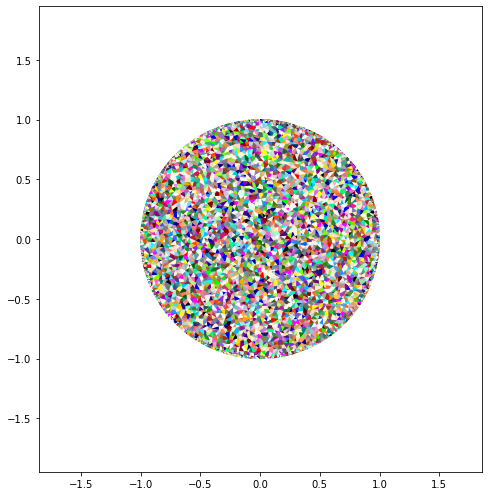

In [298]:
all_colors = 100*list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
colors = sample(all_colors, triangles_s.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

for index, triangle in enumerate(tqdm(triangles_s)):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)
    
if False:
    for idx, point in enumerate(tqdm(points)):

        if vertex_maker_is_boundary[idx] == 0:
            color = "red"
        else:
            color = "green" 
        ax.scatter(point[0], point[1], color=color)
    
ax.set_xlim([points[:, 0].min()-1, points[:, 0].max()+1])
ax.set_ylim([points[:, 1].min()-1, points[:, 1].max()+1])
fig.tight_layout()
plt.show()

### Initialize variables

In [299]:
total_points = points.shape[0]
num_midpoints = is_middle.sum()
num_nodes = total_points - num_midpoints
NUM = 6 * num_nodes + num_midpoints

In [300]:
x, y = sympy.symbols("x y")

In [301]:
right_part_values = np.zeros((total_points, 6))

### Define the right part of the equation

In [302]:
F = 1*sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)
F_xx = F_x.diff(x)
F_xy = F_x.diff(y)
F_yy = F_y.diff(y)

In [303]:
right_part_values[:, 0] = sympy.lambdify((x, y), F)(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x)(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y)(*points.T)
right_part_values[:, 3] = sympy.lambdify((x, y), F_xx)(*points.T)
right_part_values[:, 4] = sympy.lambdify((x, y), F_xy)(*points.T)
right_part_values[:, 5] = sympy.lambdify((x, y), F_yy)(*points.T)

### This is for Green's function

In [304]:
# right_part_values = get_delta_function(np.array([0, 0]), points, triangles, elem_normal, elem_tangential, global_elem_normal, global_elem_tangential, num_nodes, basis_integral_values)

### Stiffnes matrix assembling

In [305]:
matrix = np.zeros((NUM, NUM), dtype=np.float64)
b = np.zeros((NUM),  dtype=np.float64)

for idx, element in enumerate(tqdm(triangles)):
#----------------P's----------------------------------------------------------------
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    delta = x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2
    
    P_1_x = (-y1 + y3) / delta
    P_1_y = (+x1 - x3) / delta
    
    P_2_x = (+y1 - y2) / delta
    P_2_y = (-x1 + x2) / delta
#------------------------------------------------------------------------------------
#----------------------Lengths-------------------------------------------------------
    l1 = ((x2 - x3)**2 + (y2 - y3)**2)**0.5
    l2 = ((x1 - x3)**2 + (y1 - y3)**2)**0.5
    l3 = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
#------------------------------------------------------------------------------------
#----------------------Jacobian------------------------------------------------------

    J = np.array([
                [P_1_x, P_1_y], 
                [P_2_x, P_2_y]
                ])

    J_inv_T = np.linalg.inv(J.T)
#-----------------------------------------------------------------------------------
#-----------------------nomal-and-tangential-vectors--------------------------------
    n1 = elem_normal[idx, 3]
    t1 = elem_tangential[idx, 3]


    n2 = elem_normal[idx, 4]
    t2 = elem_tangential[idx, 4]

    
    n3 = elem_normal[idx, 5]
    t3 = elem_tangential[idx, 5]
    
    
    DN_n1 = global_elem_normal[triangles[idx]][3]
    DN_t1 = global_elem_tangential[triangles[idx]][3]


    DN_n2 = global_elem_normal[triangles[idx]][4]
    DN_t2 = global_elem_tangential[triangles[idx]][4]

    
    DN_n3 = global_elem_normal[triangles[idx]][5]
    DN_t3 = global_elem_tangential[triangles[idx]][5]
#------------------------------------------------------------------------------------
#------------------------G's---------------------------------------------------------
    G1 = np.array([
        [*n1],
        [*t1]
    ])
    
    G2 = np.array([
        [*n2],
        [*t2]
    ])
    
    G3 = np.array([
        [*n3],
        [*t3]
    ])
    
    G1_hat = np.array([
        [+np.sqrt(1/2), +np.sqrt(1/2)],
        [-np.sqrt(1/2), +np.sqrt(1/2)],
    ])
    
    G2_hat = np.array([
        [-1, +0],
        [+0, -1],
    ])
    
    G3_hat = np.array([
        [+0, -1],
        [+1, +0]
    ])

    B1 = G1_hat @ J_inv_T @ G1.T
    B2 = G2_hat @ J_inv_T @ G2.T
    B3 = G3_hat @ J_inv_T @ G3.T
                                                        
    DN_G1 = np.array([
        [*DN_n1],
        [*DN_t1]
    ])
    
    DN_G2 = np.array([
        [*DN_n2],
        [*DN_t2]
    ])
    
    DN_G3 = np.array([
        [*DN_n3],
        [*DN_t3]
    ])

    DN_B1 = G1_hat @ J_inv_T @ DN_G1.T
    DN_B2 = G2_hat @ J_inv_T @ DN_G2.T
    DN_B3 = G3_hat @ J_inv_T @ DN_G3.T                                                            
#------------------------------------------------------------------------------------
#----------------------Theta---------------------------------------------------------

    THETA = np.array([
        [P_1_x**2, 2*P_1_x*P_2_x, P_2_x**2],
        [P_1_y*P_1_x, P_1_y*P_2_x + P_1_x*P_2_y, P_2_x*P_2_y],
        [P_1_y**2, 2*P_1_y*P_2_y, P_2_y**2],
    ])
    
#------------------------------------------------------------------------------------
#-------------------------right-part-interp------------------------------------------
    
    right_part_interp = [
                        *right_part_values[element[0]],
                        *right_part_values[element[1]],
                        *right_part_values[element[2]],
                        DN_n1@right_part_values[element[3]][1:3],
                        DN_n2@right_part_values[element[4]][1:3],
                        DN_n3@right_part_values[element[5]][1:3]
                        ]
#------------------------------------------------------------------------------------
#--------------------args------------------------------------------------------------
    args = [
        *n1, *n2, *n3, 
        *t1, *t2, *t3,
        l1, l2, l3,
        *J.flatten(),
        *THETA.flatten(),
        *B1.flatten(),
        *B2.flatten(),
        *B3.flatten(),
        *DN_B1.flatten(),
        *DN_B2.flatten(),
        *DN_B3.flatten(),
        *right_part_interp
       ]

    vals = biharmonic_functional(*args)
    vals_A = basis_integral_values(*args)
#------------------------------------------------------------------------------------
#---------------------------------------p1-------------------------------------------------------------------------------------------------
    if vertex_maker_is_boundary[element[0]] == True:
        
        matrix[6 * element[0], 6 * element[0]] = 1

        
        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[0]+i, 6*element[j]+k] += 2 * vals[i, 6*j + k]
                    
                for k in range(3,6):
                    matrix[6*element[0]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[i, 18+(k-3)] 

        
        b[6 * element[0]+0] = 0
        b[6 * element[0]+1] += 2 * vals_A[1]
        b[6 * element[0]+2] += 2 * vals_A[2]
        b[6 * element[0]+3] += 2 * vals_A[3]
        b[6 * element[0]+4] += 2 * vals_A[4]
        b[6 * element[0]+5] += 2 * vals_A[5]
    
    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[0]+i, 6*element[j]+k] += 2 * vals[i, 6*j + k] 
                    
                for k in range(3,6):
                    matrix[6*element[0]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[i, 18 + (k-3)] 

        b[6 * element[0]+0] += 2 * vals_A[0]
        b[6 * element[0]+1] += 2 * vals_A[1]
        b[6 * element[0]+2] += 2 * vals_A[2]
        b[6 * element[0]+3] += 2 * vals_A[3]
        b[6 * element[0]+4] += 2 * vals_A[4]
        b[6 * element[0]+5] += 2 * vals_A[5]
#------------------------------------------------------------------------------------------------------------------------------------------     
#---------------------------------------p2-------------------------------------------------------------------------------------------------
    if vertex_maker_is_boundary[element[1]] == True:
        
        matrix[6 * element[1], 6 * element[1]] = 1
        

        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[1]+i, 6*element[j]+k] += 2 * vals[6 + i, 6*j + k] 
                    
                for k in range(3,6):
                    matrix[6*element[1]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[6 + i, 18 + (k-3)] 

            
        b[6 * element[1]+0] = 0
        b[6 * element[1]+1] += 2 * vals_A[7 ]
        b[6 * element[1]+2] += 2 * vals_A[8 ]
        b[6 * element[1]+3] += 2 * vals_A[9 ]
        b[6 * element[1]+4] += 2 * vals_A[10]
        b[6 * element[1]+5] += 2 * vals_A[11]
    
    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[1]+i, 6*element[j]+k] += 2 * vals[6 + i, 6*j + k] 
                    
                for k in range(3,6):
                    matrix[6*element[1]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[6 + i, 18 + (k-3)] 
           
        b[6 * element[1]+0] += 2 * vals_A[6 ]
        b[6 * element[1]+1] += 2 * vals_A[7 ]
        b[6 * element[1]+2] += 2 * vals_A[8 ]
        b[6 * element[1]+3] += 2 * vals_A[9 ]
        b[6 * element[1]+4] += 2 * vals_A[10]
        b[6 * element[1]+5] += 2 * vals_A[11]
#------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------p3-------------------------------------------------------------------------------------------------
    if vertex_maker_is_boundary[element[2]] == True:
        
        matrix[6 * element[2], 6 * element[2]] = 1
    
    
        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[2]+i, 6*element[j]+k] += 2 * vals[12 + i, 6*j + k] 
                    
                for k in range(3,6):
                    matrix[6*element[2]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[12 + i, 18 + (k-3)]
    
        b[6 * element[2]+0] = 0
        b[6 * element[2]+1] += 2 * vals_A[13]
        b[6 * element[2]+2] += 2 * vals_A[14]
        b[6 * element[2]+3] += 2 * vals_A[15]
        b[6 * element[2]+4] += 2 * vals_A[16]
        b[6 * element[2]+5] += 2 * vals_A[17]
    
    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[2]+i, 6*element[j]+k] += 2 * vals[12 + i, 6*j + k] 

                for k in range(3,6):
                    matrix[6*element[2]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[12 + i, 18 + (k-3)]
    
        b[6 * element[2]+0] += 2 * vals_A[12]
        b[6 * element[2]+1] += 2 * vals_A[13]
        b[6 * element[2]+2] += 2 * vals_A[14]
        b[6 * element[2]+3] += 2 * vals_A[15]
        b[6 * element[2]+4] += 2 * vals_A[16]
        b[6 * element[2]+5] += 2 * vals_A[17]
#------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------m1--------------------------------------------------------------------------------------------
    if vertex_maker_is_boundary[element[3]] == True:

        matrix[6*num_nodes+(element[3]-num_nodes), 6*num_nodes+(element[3]-num_nodes)] = 1

        b[6*num_nodes+(element[3]-num_nodes)] = 0
        
    else:

        for j in range(3):
            for k in range(6):
                matrix[6*num_nodes+(element[3]-num_nodes), 6*element[j]+k] += 2 * vals[18, 6*j + k] 

            for k in range(3,6):
                matrix[6*num_nodes+(element[3]-num_nodes), 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[18, 18 + (k-3)]

        b[6*num_nodes+(element[3]-num_nodes)] += 2 * vals_A[18]
#------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------m2--------------------------------------------------------------------------------------------
    if vertex_maker_is_boundary[element[4]] == True:

        matrix[6*num_nodes+(element[4]-num_nodes), 6*num_nodes+(element[4]-num_nodes)] = 1
        b[6*num_nodes+(element[4]-num_nodes)] = 0
        
    else:

        for j in range(3):
            for k in range(6):
                matrix[6*num_nodes+(element[4]-num_nodes), 6*element[j]+k] += 2 * vals[19, 6*j + k] 

            for k in range(3,6):
                matrix[6*num_nodes+(element[4]-num_nodes), 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[19, 18 + (k-3)]

        b[6*num_nodes+(element[4]-num_nodes)] += 2 * vals_A[19] 
#------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------m2--------------------------------------------------------------------------------------------
    if vertex_maker_is_boundary[element[5]] == True:
        
        matrix[6*num_nodes+(element[5]-num_nodes), 6*num_nodes+(element[5]-num_nodes)] = 1
        b[6*num_nodes+(element[5]-num_nodes)] = 0
        
    else:

        for j in range(3):
            for k in range(6):
                matrix[6*num_nodes+(element[5]-num_nodes), 6*element[j]+k] += 2 * vals[20, 6*j + k] 

            for k in range(3,6):
                matrix[6*num_nodes+(element[5]-num_nodes), 6*num_nodes+(element[k]-num_nodes)] += 2 * vals[20, 18 + (k-3)]

        b[6*num_nodes+(element[5]-num_nodes)] += 2 * vals_A[20] 
#------------------------------------------------------------------------------------------------------------------------------------------

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6182/6182 [14:59<00:00,  6.87it/s]


### Visualize stiffness matrix

In [306]:
# fig, ax = plt.subplots()
# ax.imshow(matrix != 0)
# plt.show()

### Solve the system

In [307]:
c = np.linalg.solve(matrix, b)

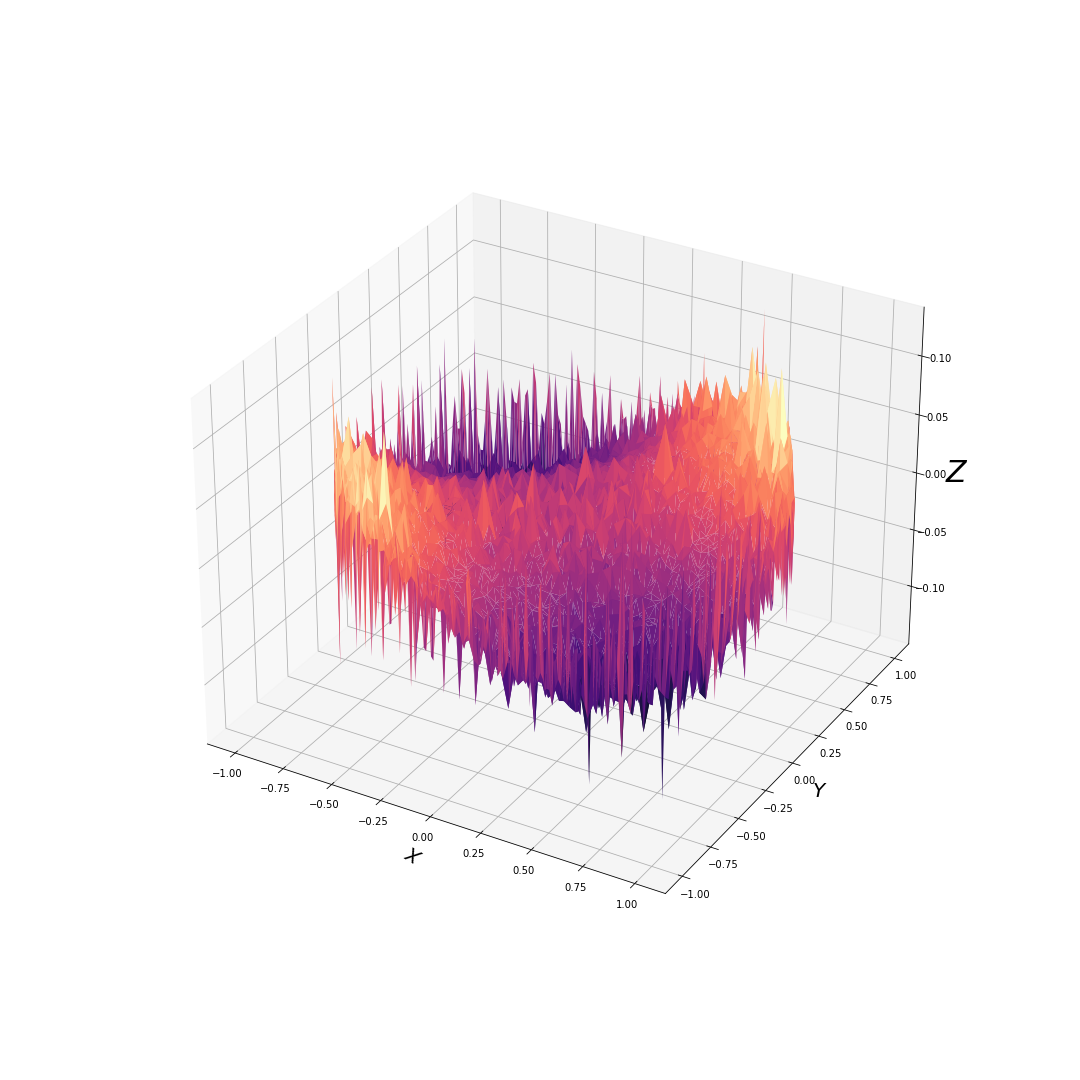

In [313]:
%matplotlib widget

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
ax.set_xlabel('$X$', fontsize=20, rotation=150)
ax.set_ylabel('$Y$', fontsize=20, rotation=0)
ax.set_zlabel('$Z$', fontsize=30, rotation=0)

_x_ = points[:num_nodes, 0]
_y_ = points[:num_nodes, 1]

F   = c[0:6*num_nodes:6]
Fx  = c[1:6*num_nodes:6]
Fy  = c[2:6*num_nodes:6]
Fxx = c[3:6*num_nodes:6]
Fxy = c[4:6*num_nodes:6]
Fyy = c[5:6*num_nodes:6]
Fn  = c[6*num_nodes:]

org = (1-_x_**2-_y_**2)**2/64

ax.plot_trisurf(_x_, _y_, Fxy , 
                triangles=triangles[:, :3], 
                cmap="magma",
                )
# ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(F)))
plt.show()

In [309]:
abs(F-org).max()/abs(org).max()*100

2.19588184648351